# Water solubility predictor (regression)

## Dataset ESOL: Water solubility data (log solubility in mols per litre) for common organic small molecules.
### (from https://moleculenet.org/datasets-1 and Delaney "ESOL:  Estimating Aqueous Solubility Directly from Molecular Structure" *J. Chem. Inf. Comput. Sci.* 2004, **44**, 3, 1000–1005)

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import MinMaxScaler, power_transform, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, RandomForestRegressor
from sklearn import metrics

In [3]:
# !pip install pycm
from pycm import ConfusionMatrix

In [4]:
import sklearn_relief as sr

In [5]:
from rdkit.Chem import SmilesMolSupplier, Draw

In [6]:
from padelpy import from_smiles, padeldescriptor

In [7]:
df = pd.read_csv('Input/solubility_delaney_processed.csv')
df

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.770,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.300,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.060,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.870,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.330,c1ccsc1
...,...,...,...,...,...,...,...,...,...,...
1123,halothane,-2.608,1,197.381,0,0,0,0.00,-1.710,FC(F)(F)C(Cl)Br
1124,Oxamyl,-0.908,1,219.266,1,0,1,71.00,0.106,CNC(=O)ON=C(SC)C(=O)N(C)C
1125,Thiometon,-3.323,1,246.359,0,0,7,18.46,-3.091,CCSCCSP(=S)(OC)OC
1126,2-Methylbutane,-2.245,1,72.151,0,0,1,0.00,-3.180,CCC(C)C


In [8]:
df.describe()

,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre
count,1128.000000,1128.000000,1128.000000,1128.000000,1128.000000,1128.000000,1128.000000,1128.000000
mean,-2.988192,1.058511,203.937074,0.701241,1.390957,2.177305,34.872881,-3.050102
std,1.683220,0.238560,102.738077,1.089727,1.318286,2.640974,35.383593,2.096441
min,-9.702000,0.000000,16.043000,0.000000,0.000000,0.000000,0.000000,-11.600000
25%,-3.948250,1.000000,121.183000,0.000000,0.000000,0.000000,0.000000,-4.317500
50%,-2.870000,1.000000,182.179000,0.000000,1.000000,1.000000,26.300000,-2.860000
75%,-1.843750,1.000000,270.372000,1.000000,2.000000,3.000000,55.440000,-1.600000
max,1.091000,2.000000,780.949000,11.000000,8.000000,23.000000,268.680000,1.580000


In [9]:
df.shape

(1128, 10)

In [10]:
y = df[['smiles', 'Compound ID', 'measured log solubility in mols per litre', 'ESOL predicted log solubility in mols per litre']]

In [11]:
y = y.rename(columns={'measured log solubility in mols per litre': 'measured', \
                      'ESOL predicted log solubility in mols per litre':'ESOL'})

In [12]:
y.head()

,smiles,Compound ID,measured,ESOL
0,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,Amigdalin,-0.77,-0.974
1,Cc1occc1C(=O)Nc2ccccc2,Fenfuram,-3.30,-2.885
2,CC(C)=CCCC(C)=CC(=O),citral,-2.06,-2.579
3,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,Picene,-7.87,-6.618
4,c1ccsc1,Thiophene,-1.33,-2.232


In [13]:
import matplotlib.pyplot as plt

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  3.,  3.,  6.,  6.,
        11.,  7.,  4., 12., 11.,  6., 14., 15., 16., 15., 19., 30., 29.,
        43., 48., 48., 42., 57., 57., 54., 52., 61., 66., 64., 49., 40.,
        48., 40., 34., 27., 21., 14., 23., 13.,  7.,  8.,  3.]),
 array([-1.16000e+01, -1.13364e+01, -1.10728e+01, -1.08092e+01,
        -1.05456e+01, -1.02820e+01, -1.00184e+01, -9.75480e+00,
        -9.49120e+00, -9.22760e+00, -8.96400e+00, -8.70040e+00,
        -8.43680e+00, -8.17320e+00, -7.90960e+00, -7.64600e+00,
        -7.38240e+00, -7.11880e+00, -6.85520e+00, -6.59160e+00,
        -6.32800e+00, -6.06440e+00, -5.80080e+00, -5.53720e+00,
        -5.27360e+00, -5.01000e+00, -4.74640e+00, -4.48280e+00,
        -4.21920e+00, -3.95560e+00, -3.69200e+00, -3.42840e+00,
        -3.16480e+00, -2.90120e+00, -2.63760e+00, -2.37400e+00,
        -2.11040e+00, -1.84680e+00, -1.58320e+00, -1.31960e+00,
        -1.05600e+00, -7.92400e-01, -5.28800e-01, -2.65200e-01,
        -1.6

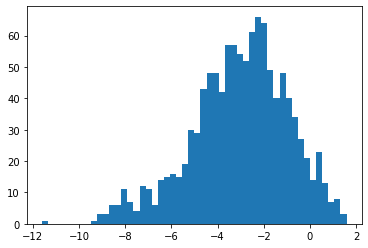

In [14]:
plt.hist(y['measured'], bins = 50)

In [15]:
y.loc[y.measured <= -2].shape

(761, 4)

In [16]:
y[['smiles', 'measured']].to_csv('Output/esol.smi', header=None, index=None, sep='\t')

In [20]:
padeldescriptor(mol_dir='Output/esol.smi', d_file='Output/esol_descriptors.csv', d_2d=True, d_3d=True)

In [21]:
x1 = pd.read_csv('Output/esol_descriptors.csv', low_memory = False)
x1

,Name,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nAromBond,nAtom,nHeavyAtom,...,P1s,P2s,E1s,E2s,E3s,Ts,As,Vs,Ks,Ds
0,-3.300,0,-0.3494,0.122080,14.7931,31.158723,11,11,26,15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-2.060,0,2.4893,6.196614,50.2393,29.070688,0,0,27,11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.770,0,-4.0765,16.617852,76.9126,63.125411,6,6,59,32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-1.330,0,0.5906,0.348808,7.7935,12.607172,5,5,9,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-1.500,0,0.5906,0.348808,7.7935,19.653965,9,10,14,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1123,-7.660,0,5.2101,27.145142,39.3092,38.380379,12,13,22,19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1124,0.106,0,0.3157,0.099666,53.0132,29.594309,0,0,27,14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1125,-3.091,0,2.5297,6.399382,64.0447,34.495895,0,0,27,12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1126,-3.180,0,0.3362,0.113030,23.0781,16.801516,0,0,17,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
x1 = x1.rename(columns={'Name': 'Measured'})

In [67]:
x1 = x1.dropna(axis=1, how='all')

In [68]:
# replacing Infinity with Nan
x1 = x1.replace([np.inf, -np.inf, 'Infinity', '=-Infinity', '#NAME\?'], np.nan, regex=True)

In [69]:
# check for missing values
x1.isna().values.any()

True

In [70]:
# replacing missing values with numeric column Median (or '.' for non-numeric)
x2 = x1.apply(lambda a: a.fillna(a.median()) if a.dtype.kind in 'biufc' else a.fillna('.'))

In [71]:
# check for missing values
x2.isin([np.nan, np.inf, -np.inf]).values.any()

False

In [72]:
x2.shape

(1128, 1445)

In [73]:
x2

,Measured,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nAromBond,nAtom,nHeavyAtom,...,AMW,WTPT-1,WTPT-2,WTPT-3,WTPT-4,WTPT-5,WPATH,WPOL,XLogP,Zagreb
0,-3.300,0,-0.3494,0.122080,14.7931,31.158723,11,11,26,15,...,7.733807,30.174160,2.011611,8.556221,5.511983,3.044238,384.0,18.0,3.085,74.0
1,-2.060,0,2.4893,6.196614,50.2393,29.070688,0,0,27,11,...,5.634078,20.486117,1.862374,2.404409,2.404409,0.000000,194.0,9.0,2.701,42.0
2,-0.770,0,-4.0765,16.617852,76.9126,63.125411,6,6,59,32,...,7.748448,64.154023,2.004813,32.578389,30.089924,2.488464,3080.0,56.0,-0.640,164.0
3,-1.330,0,0.5906,0.348808,7.7935,12.607172,5,5,9,5,...,9.333708,9.687500,1.937500,2.875000,0.000000,0.000000,15.0,0.0,2.119,20.0
4,-1.500,0,0.5906,0.348808,7.7935,19.653965,9,10,14,9,...,9.643876,18.559054,2.062117,6.100841,0.000000,3.050420,79.0,9.0,2.140,46.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1123,-7.660,0,5.2101,27.145142,39.3092,38.380379,12,13,22,19,...,17.809338,37.527354,1.975124,17.657884,0.000000,0.000000,642.0,35.0,5.432,100.0
1124,0.106,0,0.3157,0.099666,53.0132,29.594309,0,0,27,14,...,8.113621,26.151609,1.867972,19.223155,7.855698,8.612340,337.0,17.0,0.370,58.0
1125,-3.091,0,2.5297,6.399382,64.0447,34.495895,0,0,27,12,...,9.111007,22.418363,1.868197,17.045679,5.397074,0.000000,234.0,13.0,3.321,48.0
1126,-3.180,0,0.3362,0.113030,23.0781,16.801516,0,0,17,5,...,4.240818,8.696802,1.739360,0.000000,0.000000,0.000000,18.0,2.0,3.124,16.0


In [74]:
x2.to_csv('Output/esol_descriptors_clean.csv')

In [86]:
scaler = MinMaxScaler()
x2_scaled = scaler.fit_transform(x2.iloc[:,1:])
x2_scaled

array([[0.        , 0.453257  , 0.00220369, ..., 0.15929204, 0.39597955,
        0.23125   ],
       [0.        , 0.65243047, 0.11185578, ..., 0.07964602, 0.3767295 ,
        0.13125   ],
       [0.        , 0.19175016, 0.29997071, ..., 0.49557522, 0.20924403,
        0.5125    ],
       ...,
       [0.        , 0.65526508, 0.11551596, ..., 0.11504425, 0.40781031,
        0.15      ],
       [0.        , 0.50136117, 0.00204033, ..., 0.01769912, 0.39793463,
        0.05      ],
       [0.        , 0.66400747, 0.12717565, ..., 0.26548673, 0.41477842,
        0.2875    ]])

In [87]:
x2_scaled.shape

(1128, 1444)

In [91]:
rf_reg = RandomForestRegressor(n_estimators=30, random_state=42)
rf_reg

RandomForestRegressor(n_estimators=30, random_state=42)

In [92]:
X_train, X_test, y_train, y_test = train_test_split(x2_scaled, \
                                   x2.Measured, random_state=42, test_size=0.2, shuffle=True)

In [93]:
rf_reg.fit(X_train, y_train)

RandomForestRegressor(n_estimators=30, random_state=42)

In [94]:
predicted = rf_reg.predict(X_test) # The predictions from your ML / RF model

print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, predicted))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, predicted))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(y_test, predicted, squared=False))
print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(y_test, predicted))
print('Explained Variance Score:', metrics.explained_variance_score(y_test, predicted))
print('Max Error:', metrics.max_error(y_test, predicted))
print('Median Absolute Error:', metrics.median_absolute_error(y_test, predicted))
print('R^2:', metrics.r2_score(y_test, predicted))


Mean Absolute Error (MAE): 0.4859153638151426
Mean Squared Error (MSE): 0.4574700527691741
Root Mean Squared Error (RMSE): 0.676365324931116
Mean Absolute Percentage Error (MAPE): 0.4447242533836387
Explained Variance Score: 0.9005240564338721
Max Error: 2.7802
Median Absolute Error: 0.3325333333333331
R^2: 0.9000915690874347


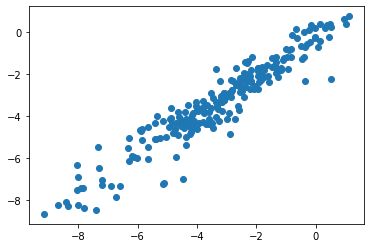

In [95]:
plt.scatter(x=y_test, y=predicted)

In [96]:
df_predicted = pd.DataFrame(predicted, columns=['Predicted'])
df_predicted['Measured'] = y_test.reset_index(drop=True)
df_predicted['Difference'] = df_predicted.Predicted - df_predicted.Measured
df_predicted

,Predicted,Measured,Difference
0,-4.813967,-4.800,-0.013967
1,-2.206967,-2.253,0.046033
2,-7.330600,-6.590,-0.740600
3,-0.210000,0.450,-0.660000
4,-7.055533,-7.200,0.144467
...,...,...,...
221,-4.026500,-4.600,0.573500
222,-4.358100,-4.860,0.501900
223,-2.461733,-2.640,0.178267
224,-5.101833,-5.410,0.308167


In [97]:
# using RReliefF for selection of important features

# RR = sr.RReliefF(n_features=50)
# top50_RR = RR.fit_transform(X_train, y_train)

In [125]:
# using <feature_importances_> for selection of features with importance above THRESHOLD

feature_importances = pd.DataFrame(rf_reg.feature_importances_, columns=['Importance']).set_index(x2.columns[1:])
feature_importances.sort_values('Importance', ascending=False)

,Importance
XLogP,0.368061
CrippenLogP,0.329643
SpMax3_Bhm,0.026396
VP-6,0.013581
LipoaffinityIndex,0.012659
...,...
minsGeH3,0.000000
minssGeH2,0.000000
minsssGeH,0.000000
minssssGe,0.000000


In [128]:
THRESHOLD = 0.002
important_features = feature_importances[feature_importances.Importance >= THRESHOLD].index.to_list()
important_features

['ATS0p',
 'AATS5i',
 'ATSC0p',
 'AATSC3c',
 'BCUTp-1h',
 'SpMax1_Bhm',
 'SpMax2_Bhm',
 'SpMax3_Bhm',
 'SpMax4_Bhm',
 'SpMax1_Bhi',
 'VP-4',
 'VP-5',
 'VP-6',
 'CrippenLogP',
 'meanI',
 'LipoaffinityIndex',
 'MAXDP',
 'ETA_Eta_F',
 'BIC0',
 'ZMIC1',
 'piPC6',
 'XLogP']

In [122]:
# Check correlation for most important features
x2.XLogP.corr(x2.CrippenLogP)

0.7947041709359353

In [123]:
x2.Measured.corr(x2.CrippenLogP)

-0.8066852491435833

In [124]:
x2.Measured.corr(x2.XLogP)

-0.7813754791958674

In [142]:
# Preparing new dataset with most important features only

x3 = pd.concat([x2.Measured, x2[important_features]], axis=1)
x3

,Measured,ATS0p,AATS5i,ATSC0p,AATSC3c,BCUTp-1h,SpMax1_Bhm,SpMax2_Bhm,SpMax3_Bhm,SpMax4_Bhm,...,VP-6,CrippenLogP,meanI,LipoaffinityIndex,MAXDP,ETA_Eta_F,BIC0,ZMIC1,piPC6,XLogP
0,-3.300,40.853950,166.156961,6.056659,-0.003647,8.889080,3.886827,3.748547,3.174571,2.688902,...,0.287093,3.14081,2.377778,4.914852,4.724911,13.03107,0.297135,33.068074,4.789573,3.085
1,-2.060,35.646010,168.100113,6.253875,-0.000881,8.432452,3.637912,3.455576,2.993826,2.677831,...,0.271369,2.73038,2.303030,4.584323,3.020498,4.66116,0.237583,25.250690,3.044522,2.701
2,-0.770,76.067792,167.474505,12.325317,0.007518,9.339813,3.823305,3.741142,3.683026,3.349676,...,1.241967,-3.44912,2.932292,-4.704292,4.253329,29.85097,0.264152,74.732503,5.102531,-0.640
3,-1.330,21.344052,0.000000,4.678138,-0.000410,7.866549,4.155062,2.634151,2.224170,0.684705,...,0.000000,1.74810,1.729630,2.414481,0.337963,2.35448,0.395097,19.288222,0.000000,2.119
4,-1.500,31.365365,167.307143,5.514561,0.000614,10.299629,4.278925,3.401119,2.818987,2.259134,...,0.385578,2.70149,1.886831,3.537353,1.268909,5.97591,0.364286,26.195950,5.146677,2.140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1123,-7.660,68.067439,149.161740,4.825699,-0.000299,12.944822,4.296804,4.128860,3.695096,3.611964,...,1.217043,7.36759,1.601040,7.603218,0.566028,17.98733,0.285627,96.636743,6.258505,5.432
1124,0.106,39.271880,168.127723,8.200354,0.007292,10.471723,3.903426,3.435159,3.361259,2.843163,...,0.128279,0.25679,2.760582,2.167333,4.411582,9.87559,0.389698,29.357173,3.496508,0.370
1125,-3.091,63.095902,157.539827,20.392094,0.000899,11.312833,4.821749,3.818684,3.242783,2.792395,...,2.985465,2.66060,1.700360,4.918593,2.176018,2.77060,0.370098,33.345785,2.079442,3.321
1126,-3.180,19.279855,184.917652,3.552086,-0.000289,7.020914,3.436053,2.757163,2.333553,1.747016,...,0.000000,2.05240,1.766667,3.875088,0.222222,0.00000,0.218495,15.090860,0.000000,3.124


In [144]:
x3_scaled = scaler.fit_transform(x3.iloc[:,1:])
x3_scaled

array([[0.24644921, 0.7402418 , 0.18347057, ..., 0.23832988, 0.59471872,
        0.39597955],
       [0.21107823, 0.74889869, 0.18965727, ..., 0.17463707, 0.37803673,
        0.3767295 ],
       [0.48561255, 0.74611156, 0.38011911, ..., 0.57779446, 0.63357851,
        0.20924403],
       ...,
       [0.39751081, 0.70185182, 0.63317482, ..., 0.24059256, 0.25820315,
        0.40781031],
       [0.09992353, 0.8238221 , 0.10490184, ..., 0.09185897, 0.        ,
        0.39793463],
       [0.42164819, 0.69180898, 0.44434365, ..., 0.43063043, 0.64719792,
        0.41477842]])

In [145]:
X_train, X_test, y_train, y_test = train_test_split(x3_scaled, \
                                   x3.Measured, random_state=42, test_size=0.2, shuffle=True)



In [149]:
# Predictor based on most important feautures only
rf_reg2 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg2.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [150]:
predicted = rf_reg2.predict(X_test) # The predictions from your ML / RF model

print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, predicted))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, predicted))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(y_test, predicted, squared=False))
print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(y_test, predicted))
print('Explained Variance Score:', metrics.explained_variance_score(y_test, predicted))
print('Max Error:', metrics.max_error(y_test, predicted))
print('Median Absolute Error:', metrics.median_absolute_error(y_test, predicted))
print('R^2:', metrics.r2_score(y_test, predicted))

Mean Absolute Error (MAE): 0.48857864306784654
Mean Squared Error (MSE): 0.4365555180755164
Root Mean Squared Error (RMSE): 0.6607234807962529
Mean Absolute Percentage Error (MAPE): 0.41153314107813765
Explained Variance Score: 0.9048183233376605
Max Error: 2.5119400000000063
Median Absolute Error: 0.3572399999999999
R^2: 0.9046591650029734


# 1:51:00